In [2]:
import json
import csv
from collections import Counter 
from textstat.textstat import textstat
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from wordfreq import word_frequency

In [2]:
tokenizer = RegexpTokenizer(r'\w+')
with open('reading-1.json') as json_data:
    reading_data = json.load(json_data)

In [3]:
def get_word_freq(word):
    return word_frequency(word, 'en') * 1e4
get_word_freq('hello')

0.47863009232263803

In [39]:
reading_data_hash = {}
i = 0
for item in reading_data:
    unique_word_list = list(map(lambda x: x.lower(), tokenizer.tokenize(item['text'])))
    word_freq_list = []
    for word in sorted(list(set(unique_word_list))):
        word_freq = get_word_freq(word)
        word_freq_list.append([word, word_freq])
    reading = {
        'text': item['text'],
        'flesch_kincaid': textstat.flesch_reading_ease(item['text']),
        'unique_word_count': len(set(unique_word_list)),
        'word_freq_list': word_freq_list
    }
    reading_data_hash[item['_id']] = reading
    i+=1
    if i>6:
        break

In [40]:
print(len(reading_data_hash))

7


In [41]:
reading_data_dfs = []
for key, item in reading_data_hash.items():
    reading_data_df = pd.DataFrame(item['word_freq_list'])
    reading_data_dfs.append(reading_data_df)

### weighted

In [46]:
with open('data-usable-final.json') as json_data:
    user_data = json.load(json_data)
    
label_row = [ 'user_id', 'reading_id', 'relative_difficulty', 'weighted_r_d', 'unknown_count', 'unique_word_count' ]
data_rows = []
i = 0
for user in user_data['users']:
    user_id = i
    i = i + 1
    j = 0
    for performance in user['performances']:
        reading_id = j
        performance_id = performance['performance']['_id']
        knowns = list(map(lambda x: x['content'].lower(),  performance['knonws']))
        unknown_list = list(set(knowns))
        unknown_count = len(unknown_list)
        unique_word_count = reading_data_hash[performance['performance']['readingId']]['unique_word_count']
        relative_difficulty = unknown_count/unique_word_count
        weighted_unknown_count = 0
        for item in unknown_list:
            word_freq = get_word_freq(item)
            weighted_unknown_count += word_freq
        weighted_relative_difficulty = weighted_unknown_count/unique_word_count
        data_row = [user_id, reading_id, relative_difficulty, weighted_relative_difficulty, unknown_count, unique_word_count]
        data_rows.append(data_row)
        j = j + 1

In [47]:
pd.DataFrame(data_rows).head()

,0,1,2,3,4,5
0,0,0,0.000000,0.000000,0,40
1,0,1,0.051948,0.046424,4,77
2,0,2,0.028369,0.052539,4,141
3,0,3,0.011834,0.003001,2,169
4,0,4,0.066351,0.107723,14,211


In [48]:
import pandas as pd

from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [52]:
def draw_graph(predictions):
    preds = []
    for i in range(0, len(predictions)):
        preds.append([predictions[i].r_ui, predictions[i].uid, predictions[i].iid, predictions[i].est])
    df = pd.DataFrame(preds)
    plt.scatter(df.iloc[:,1], df.iloc[:,0])
    plt.scatter(df.iloc[:,1], df.iloc[:,3], c='red')
    plt.xlabel('user id')
    plt.ylabel('relative difficulty')
    plt.show()
def percentCorrect(prediction, ground_truth, bound):
    in_bound = 0
    for index, x in enumerate(prediction):
        if (x <= ground_truth[index] + bound and x >= ground_truth[index] - bound):
            in_bound = in_bound + 1
    return in_bound/len(prediction)

RMSE: 0.0536
FCP:  0.4838
percent interval: 36.52%
coefficient of determination: -0.303264377652


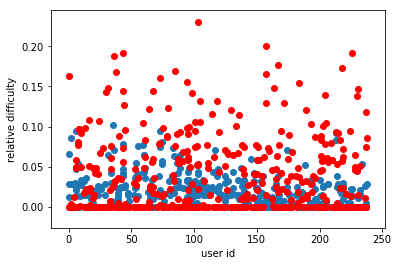

RMSE: 0.0256
FCP:  0.5521
percent interval: 55.13%
coefficient of determination: -0.86667261363


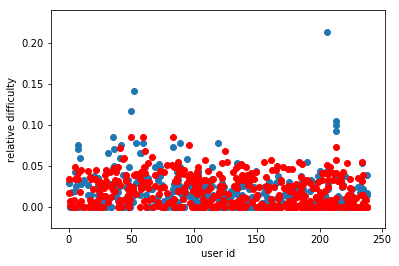

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0207
FCP:  0.5808
percent interval: 57.76%
coefficient of determination: -4.56618723624


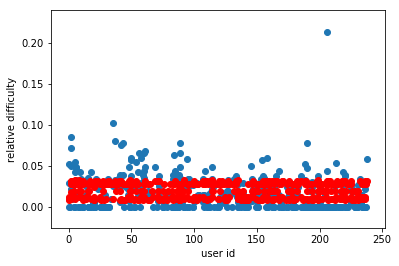

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0168
FCP:  0.5583
percent interval: 70.64%
coefficient of determination: -0.213685238616


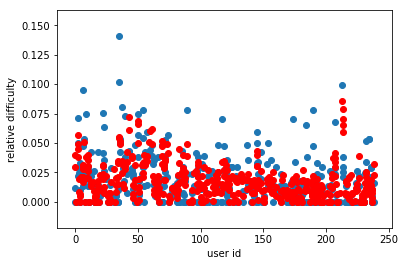

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0161
FCP:  0.5537
percent interval: 71.12%
coefficient of determination: 0.0356836935914


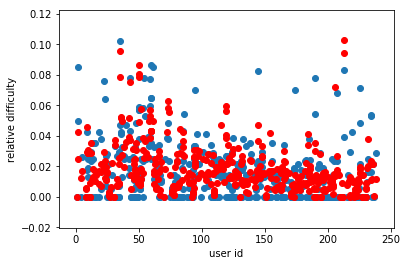

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0206
FCP:  0.5450
percent interval: 62.77%
coefficient of determination: -5.65948792422


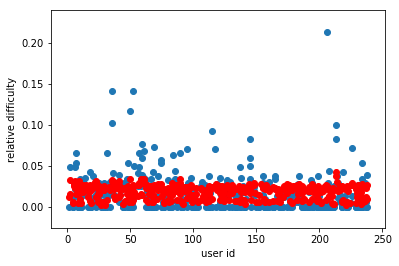

RMSE: 0.0269
FCP:  0.5051
percent interval: 53.94%
coefficient of determination: -1.62747022535


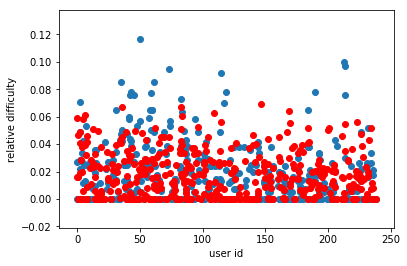

Estimating biases using als...
RMSE: 0.0184
FCP:  0.5715
percent interval: 63.01%
coefficient of determination: -7.38547383324


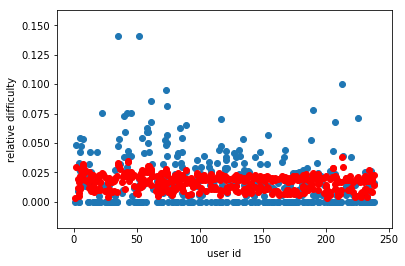

RMSE: 0.0175
FCP:  0.0000
percent interval: 71.12%
coefficient of determination: -0.078259459397


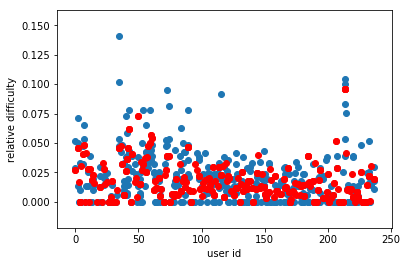

In [54]:
rec_df = pd.DataFrame(data_rows)
rec_df.columns = label_row
rec_df = rec_df.sample(frac=1).reset_index(drop=True)

reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(rec_df[['user_id', 'reading_id', 'relative_difficulty']], reader)

algos = [
    SVD(),
    SVDpp(), 
    KNNBasic(), 
    KNNWithMeans(), 
    KNNWithZScore(), 
    KNNBaseline(), 
    NormalPredictor(), 
    BaselineOnly(),
    SlopeOne()
    #     CoClustering(), #predict all 0, the RMSE is 0.0252
    #     NMF(), #predicts 0 most of the times
]

algo_names = [
    'SVD',
    'SVDpp', 
    'KNNBasic', 
    'KNNWithMeans', 
    'KNNWithZScore', 
    'KNNBaseline', 
    'NormalPredictor', 
    'BaselineOnly',
    'SlopeOne'
    #     CoClustering(), #predict all 0, the RMSE is 0.0252
    #     NMF(), #predicts 0 most of the times
]

measures = []
for index, algo in enumerate(algos):
    trainset, testset = train_test_split(data, test_size=.25)
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    fcp = accuracy.fcp(predictions)
    truth = []
    preds = []
    truth_count = []
    preds_count = []
    for i in range(0, len(predictions)):
        row = rec_df.loc[(rec_df['user_id'] == predictions[i].uid) & (rec_df['reading_id'] == predictions[i].iid)]
        preds_count.append(row.iloc[0]['unique_word_count'] * predictions[i].est)
        truth_count.append(row.iloc[0]['unknown_count'])
        truth.append(predictions[i].r_ui)
        preds.append(predictions[i].est)
    r2 = r2_score(preds, truth)
    interval = "{0:.2f}%".format(percentCorrect(truth_count, preds_count, 2) * 100)
    interval25 = "{0:.2f}%".format(percentCorrect(truth_count, preds_count, 2.5) * 100)
    print('percent interval: ' + str(interval))
    print('coefficient of determination: ' + str(r2))
    draw_graph(predictions)
    measures.append([algo_names[index], rmse, fcp, interval, interval25])

In [51]:
def generate_reading_data(_max, features_count):
    increment = math.ceil(_max/features_count)
    reading_label_row = []
    i = 0
    while i < _max:
        reading_label_row.append('reading-' + str(i) + '-' + str(i+increment))
        i += increment
    reading_data_rows = []

    for key, item in reading_data_hash.items():
        base_row_data = [0 for _ in range(0, _max, increment)]
        for item in item['word_freq_list']:
            for index, _range in enumerate(reading_label_row):
                low = int(_range.split('-')[1])
                high = int(_range.split('-')[2])
                if (item[1] <= high and item[1] > low):
                    base_row_data[index] += 1
        reading_data_rows.append(base_row_data)
    return reading_label_row, reading_data_rows

In [110]:
_max = 56235
features_count = 100
b, a = generate_reading_data(_max, features_count)
pd.DataFrame(a).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,12,5,2,2,2,3,0,2,0,1,...,0,0,0,0,0,0,0,0,0,1
1,32,8,6,3,5,4,2,0,0,2,...,0,0,0,0,0,0,0,0,0,1
2,81,14,8,5,6,3,3,2,0,2,...,0,0,0,0,0,0,0,0,0,1
3,112,8,8,4,7,3,3,1,1,3,...,0,0,0,0,0,0,0,0,0,1
4,115,15,8,6,6,5,4,2,2,2,...,0,0,0,0,0,0,0,0,0,1


In [27]:
def generate_user_data(_max, features_count):
    with open('data-usable-1.json') as json_data:
        user_data = json.load(json_data)
    increment = math.ceil(_max/features_count)
    user_label_row = []
    i = 0
    while i < _max:
        user_label_row.append('user-' + str(i) + '-' + str(i+increment))
        i += increment
    user_data_rows = []
    i = 0
    for user in user_data['users']:
        user_id = i
        i = i + 1
        j = 0
        for performance in user['performances']:
            base_row_data = [0 for _ in range(0, _max, increment)]
            reading_id = j
            performance_id = performance['performance']['_id']
            knowns = list(map(lambda x: x['content'].lower(),  performance['knonws']))
            unknown_list = list(set(knowns))
            for item in unknown_list:
                for index, _range in enumerate(user_label_row):
                    low = int(_range.split('-')[1])
                    high = int(_range.split('-')[2])
                    word_freq = get_word_freq(item)
                    if ( word_freq <= high and word_freq > low):
                        base_row_data[index] += 1
            j = j + 1
            user_data_rows.append(base_row_data)
    return user_label_row, user_data_rows

In [30]:
_max = 56235
features_count = 50
b, a = generate_user_data(_max, features_count)
pd.DataFrame(a).shape

(1673, 50)

In [22]:
def generate_final_data(_max, features_count):
    with open('data-usable-1.json') as json_data:
        user_data = json.load(json_data)
    user_label_row, user_data_rows = generate_user_data(_max, features_count)
#     reading_label_row, reading_data_rows = generate_reading_data(_max, features_count)
    final_label_row = user_label_row + ['relative_difficulty']
    final_data_rows = []
    i = 0 
    for user in user_data['users']:
        user_id = i
        i = i + 1
        j = 0
        for performance in user['performances']:
            reading_id = j
            performance_id = performance['performance']['_id']
            knowns = list(map(lambda x: x['content'].lower(),  performance['knonws']))
            unknown_count = len(list(set(knowns)))
            unique_word_count = reading_data_hash[performance['performance']['readingId']]['unique_word_count']
            difficulty = reading_data_hash[performance['performance']['readingId']]['flesch_kincaid']
            relative_difficulty = unknown_count/unique_word_count
            data_row = user_data_rows[user_id] + [relative_difficulty]
    #         data_row = [relative_difficulty, unknown_count, unique_word_count, total_counts[user_id], difficulty]
            final_data_rows.append(data_row)
            j = j + 1
    return final_label_row, final_data_rows

In [31]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

_max = 56235
features_count = 100
max_r2_train = 0
max_r2_test = 0
for features_count in range(5, 100):
    final_label_row, final_data_rows = generate_final_data(_max, features_count)
    data = pd.DataFrame(final_data_rows)
    data.columns = final_label_row
    data = data.loc[:, (data != 0).any(axis=0)]
    features = data.columns[:-1]
    target = 'relative_difficulty'

    reg = LinearRegression()
    for i in range(5,features_count) :
        rfe = RFE(reg, i)
        rfe = rfe.fit(data[features], data[target])
        filtered = data[features][data[features].columns[rfe.support_]].columns
        X_train, X_test, y_train, y_test = train_test_split(data[filtered], data[target], test_size=0.3, random_state=0)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_train)
        r2_train = reg.score(X_train, y_train)
        if r2_train > max_r2_train:
            max_r2_train = r2_train
            print('train set max r2: ' + str(max_r2_train) + ' at ' + str(i) + ' features: ' + str(features_count))
        y_pred = reg.predict(X_test)
        r2_test = reg.score(X_test, y_test)
        if r2_test > max_r2_test:
            max_r2_train = r2_train
            print('test set max r2: ' + str(max_r2_test) + ' at ' + str(i) + ' features: ' + str(features_count))

train set max r2: 0.00107663501423 at 5 features: 6


In [121]:
final_label_row, final_data_rows = generate_final_data(_max, 49)
data = pd.DataFrame(final_data_rows)
data.columns = final_label_row
data = data.loc[:, (data != 0).any(axis=0)]
features = data.columns[:-1]
target = 'relative_difficulty'
rfe = RFE(reg, 20)
rfe = rfe.fit(data[features], data[target])
filtered = data[features][data[features].columns[rfe.support_]].columns
print(filtered)

Index(['reading-1148-2296', 'reading-2296-3444', 'reading-4592-5740',
       'reading-5740-6888', 'reading-10332-11480', 'reading-12628-13776',
       'reading-26404-27552', 'user-0-1148', 'user-1148-2296',
       'user-2296-3444', 'user-3444-4592', 'user-5740-6888', 'user-6888-8036',
       'user-9184-10332', 'user-10332-11480', 'user-11480-12628',
       'user-22960-24108', 'user-25256-26404', 'user-26404-27552',
       'user-55104-56252'],
      dtype='object')


In [129]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from math import sqrt
from sklearn.metrics import mean_squared_error
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LinearRegression()
scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(modelCV, data[filtered], data[target], cv=kfold, scoring=scoring)
rmse = sqrt(abs(results.mean()))
print("10-fold cross validation average accuracy: %.3f" % (rmse))

10-fold cross validation average accuracy: 0.014


In [187]:
X_train, X_test, y_train, y_test = train_test_split(data[filtered], data[target], test_size=0.25)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_truth = y_test.values
rmse = sqrt(mean_squared_error(y_truth, y_pred))
print(rmse)

0.01204245610578532
